In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions 
from pyspark.sql.functions import udf, isnan, when, count, col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [2]:
spark_application_name = "Spark_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/11 18:38:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
stocks_path = 'stocks_data/MICROSOFT.csv'

In [4]:
df = spark.read.csv(stocks_path, header=True)

In [5]:
def moving_averge(df, column, moving_range=5):
    """Calcul la moyenne mobile

    Parameters
    ----------
    df : DataFrame
        
    column : string
        La colonne où on calcule la moyenne mobile
    moving_range: int
        La portée pour calculer la moyenne mobile. 5 par défaut
    delimiter: 
        Définit un séparateur pour chaque champ et chaque valeur. ; par défaut
    Returns
    -------
    DataFrame
        Le DataFrame avec la colonne moving_average
    """
    check = df.select(col(column), col(column).cast("int").isNotNull().alias("Value")).select("Value").collect()
    if_all_true = all(e for e in check)
    if (if_all_true):
        w = (Window.orderBy(functions.col("Date")).rowsBetween(-moving_range, 0))
        df = df.withColumn('moving_average', functions.avg(column).over(w))
        return df
    return df

In [6]:
df.columns

['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name']

In [7]:
moving_averge(df, 'Open').select('Date', 'Open', 'moving_average').show()

22/05/11 18:38:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/11 18:38:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/11 18:38:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+------------------+------------------+
|      Date|              Open|    moving_average|
+----------+------------------+------------------+
|2017-01-03|62.790000915527344|62.790000915527344|
|2017-01-04| 62.47999954223633|62.635000228881836|
|2017-01-05|62.189998626708984| 62.48666636149088|
|2017-01-06| 62.29999923706055|  62.4399995803833|
|2017-01-09|  62.7599983215332| 62.50399932861328|
|2017-01-10| 62.72999954223633| 62.54166603088379|
|2017-01-11| 62.61000061035156| 62.51166598002116|
|2017-01-12|63.060001373291016| 62.60833295186361|
|2017-01-13|62.619998931884766|62.679999669392906|
|2017-01-17| 62.68000030517578|62.743333180745445|
|2017-01-18| 62.66999816894531|62.728333155314125|
|2017-01-19|  62.2400016784668|62.646666844685875|
|2017-01-20| 62.66999816894531| 62.65666643778483|
|2017-01-23| 62.70000076293945| 62.59666633605957|
|2017-01-24| 63.20000076293945|62.693333307902016|
|2017-01-25| 63.95000076293945| 62.90500005086263|
|2017-01-26| 64.12000274658203|

In [8]:
def corr_with(df1, df2):
    df2_pd = df2.toPandas()
    df1_pd = df1.toPandas()
     
    df1_name = df1_pd.iloc[0, -1]
    df2_name = df2_pd.iloc[0, -1]
    
    df1_pd = df1_pd.drop(columns=['Date', 'company_name'])
    df2_pd = df2_pd.drop(columns=['Date', 'company_name'])
    
    cols_1 = df1_pd.columns
    cols_2 = df2_pd.columns
    
    df1_pd[cols_1] = df1_pd[cols_1].apply(pd.to_numeric, errors='coerce', axis=1)
    df2_pd[cols_2] = df2_pd[cols_2].apply(pd.to_numeric, errors='coerce', axis=1)

    new_cols_1 = [col + ' ' + df1_name for col in cols_1]
    new_cols_2 = [col + ' ' + df2_name for col in cols_2]
    df1_pd.columns = new_cols_1
    df2_pd.columns = new_cols_2
    
    corr = pd.concat([df1_pd,df2_pd],axis=1).corr()
    corr = corr.loc[new_cols_1, new_cols_2]
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+new_cols_1, rotation=90, ha='left')
    ax.set_yticklabels(['']+new_cols_2)
    cax=ax.matshow(corr,vmax=1,vmin=-1)
    fig.colorbar(cax)
    #plt.xticks(rotation=90)
    plt.show()

In [9]:
df2 = spark.read.csv('stocks_data/AMAZON.csv', header=True)

/tmp/ipykernel_9050/2317384631.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+new_cols_1, rotation=90, ha='left')
/tmp/ipykernel_9050/2317384631.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+new_cols_2)


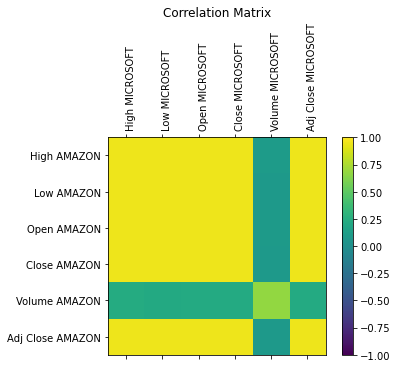

In [10]:
corr = corr_with(df, df2)
corr

In [68]:
import datetime

def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")


def RoR(df, date, period):
    
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "week":
        currentDate += datetime.timedelta(days=7)  
    elif period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
   

    tmp = df.select(col("Date"), col("Open"))
    
    # Get rows and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
    
    currentRow = tmp.filter(col("Date") == currentDate).first()
    if(currentRow == None):
        raise ValueError("Incorrect date:", currentDate.strftime("%Y-%m-%d"))
    
    # Get values
    originalVal = float(originalRow.__getitem__('Open'))
    currentValue = float(currentRow.__getitem__('Open'))
    
    # Return the calcul
    return (currentValue - originalVal) / originalVal * 100



In [69]:
print(RoR(df, "2017-01-03", "week"))
print(RoR(df, "2017-01-03", "month"))
print(RoR(df, "2017-01-03", "year"))

-0.09555880301982586
0.7325992638405951
37.06003552121619


In [88]:
from pyspark.sql.functions import lit, expr, desc

def bestRoR(df, date, period):
    
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected month or year")
    
    tmp = df.select(col("Date"), col("Open"))
    
    
    # Get originalRow and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
        
    # Get original values
    originalVal = float(originalRow.__getitem__('Open'))
    
    
    # Get the period rows and add a column corresponding to the RoR
    tmp = tmp.where(col("Date") > originalDate) \
        .where(col("Date") <= currentDate) \
        .withColumn("originalVal", lit(originalVal)) \
        .select("Date", expr("((Open - originalVal) / originalVal * 100) as RoR"))
    
    # Get the row with the highter
    bestRoRRow = tmp.orderBy(desc("RoR")).first()
    
    
    # Return the tupple (Date, RoR)
    return (bestRoRRow.__getitem__('Date'), bestRoRRow.__getitem__('RoR'))
    


('2017-01-30', 4.618572198749188)


In [ ]:
print(bestRoR(df, "2017-01-03", "month"))